In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import feature_process_helper
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
%matplotlib inline

C:\Users\User\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Model 1

#### Run model with 1000 trees

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [23]:
rf = RandomForestClassifier(criterion='entropy',
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf = rf.fit(X_train, y_train.values.ravel())
print "%.4f" % rf.oob_score_ 

0.8092


#### Obtain cross-validation score

In [24]:
scores1 = cross_val_score(rf, X_train, y_train.values.ravel(), n_jobs=-1)
scores1.mean()

0.80272727272727273

In [22]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,longitude,0.094178
3,latitude,0.093220
1,gps_height,0.060972
6,population,0.045696
0,date_recorded,0.042870
3731,quantity_group_dry,0.041938
9,construction_year,0.033380
3729,quantity_group_enough,0.023267
3750,waterpoint_type_other,0.014815
11,month_recorded,0.014388


#### Generate submission file

In [34]:
predictions = rf.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test1.csv'), sep=",", index = False)

# Model 2

#### Run model with 500 trees

In [26]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [17]:
rf2 = RandomForestClassifier(criterion='entropy',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf2 = rf2.fit(X_train, y_train.values.ravel())
print "%.4f" % rf2.oob_score_ 

0.8088


#### Obtain cross-validation score

In [28]:
scores1 = cross_val_score(rf2, X_train, y_train.values.ravel(), n_jobs=-1)
scores1.mean()

0.80249158249158248

#### Inspect feature importance

In [21]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf2.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
2,longitude,0.094282
3,latitude,0.093040
1,gps_height,0.060916
6,population,0.045731
0,date_recorded,0.042778
3731,quantity_group_dry,0.042771
9,construction_year,0.033192
3729,quantity_group_enough,0.023271
3750,waterpoint_type_other,0.014880
11,month_recorded,0.014480


#### Generate submission file

In [18]:
predictions = rf2.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv('y_test2.csv', sep=",", index = False)

# Model 3

#### Construct dataset

In [8]:
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

#### Tune parameters

In [11]:
rf = RandomForestClassifier(n_estimators=50,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

Find the right information gain criterion.

In [13]:
param_grid = { "criterion"   : ["gini", "entropy"],}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [14]:
print(gs.best_score_)

0.794191919192


In [15]:
print(gs.best_params_)

{'criterion': 'gini'}


In [17]:
print(gs.grid_scores_)

[mean: 0.79419, std: 0.00238, params: {'criterion': 'gini'}, mean: 0.79306, std: 0.00159, params: {'criterion': 'entropy'}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Find the right number of minimum samples to split.

In [18]:
param_grid = { "min_samples_split" : [2, 4, 10]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [19]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.grid_scores_)

0.799494949495
{'min_samples_split': 10}
[mean: 0.79419, std: 0.00238, params: {'min_samples_split': 2}, mean: 0.79872, std: 0.00196, params: {'min_samples_split': 4}, mean: 0.79949, std: 0.00139, params: {'min_samples_split': 10}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Find the right number of minimum samples in a leaf.

In [22]:
rf = RandomForestClassifier(criterion='gini',
                            min_samples_split=10,
                            n_estimators=50,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

In [23]:
param_grid = {"min_samples_leaf" : [1,5,10]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [24]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.grid_scores_)

0.799494949495
{'min_samples_leaf': 1}
[mean: 0.79949, std: 0.00139, params: {'min_samples_leaf': 1}, mean: 0.75559, std: 0.00112, params: {'min_samples_leaf': 5}, mean: 0.73729, std: 0.00270, params: {'min_samples_leaf': 10}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [25]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=50,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

In [26]:
param_grid = {"min_samples_split" : [10, 12, 16]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [27]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.grid_scores_)

0.8
{'min_samples_split': 12}
[mean: 0.79949, std: 0.00139, params: {'min_samples_split': 10}, mean: 0.80000, std: 0.00024, params: {'min_samples_split': 12}, mean: 0.79759, std: 0.00066, params: {'min_samples_split': 16}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### Run model with 500 trees & tuned hyperparameters

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [4]:
rf3 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf3 = rf3.fit(X_train, y_train.values.ravel())
print "%.4f" % rf3.oob_score_ 

0.8142


#### Obtain cross-validation scores

In [21]:
scores3 = cross_val_score(rf3, X_train, y_train.values.ravel(), n_jobs=-1)
scores3.mean()

0.80718855218855212

#### Let's try stratified cross-validation

In [56]:

kfold = StratifiedKFold(y=y_train.values.ravel(), n_folds=3, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    rf3.fit(X_train.values[train], y_train.values.ravel()[train])
    score = rf3.score(X_train.values[test], y_train.values.ravel()[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.array(y_train['status_group'][train].value_counts()), score))

Fold: 1, Class dist.: [21506 15216  2878], Acc: 0.807
Fold: 2, Class dist.: [21506 15216  2878], Acc: 0.810
Fold: 3, Class dist.: [21506 15216  2878], Acc: 0.805


#### Look at feature imporance

#### Generate submission file

In [5]:
predictions = rf3.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test3.csv'), sep=",", index = False)

In [62]:
y_test['status_group'].value_counts(normalize=True)

functional                 0.656162
non functional             0.327542
functional needs repair    0.016296
Name: status_group, dtype: float64

In [ ]:
rf3b = rf3.fit(X_train, y_train.values.ravel(), sample_weight=[1,2,2])

In [7]:
probs = rf3.predict_proba(X_test)

In [57]:
z = pd.concat((pd.DataFrame(probs), y_test), axis = 1)

In [59]:
z.to_csv('z.csv')

In [63]:
z[z['status_group'] == 'functional'].sort_values(by=0).head()

,0,1,2,id,status_group
2835,0.344060,0.340001,0.315939,26143,functional
12473,0.351634,0.341530,0.306836,21889,functional
5338,0.354020,0.333533,0.312446,56921,functional
4711,0.356213,0.293405,0.350382,38334,functional
734,0.356298,0.341009,0.302693,28339,functional


In [5]:
features = pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf3.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)
features[-20:]

,variable,importance
1277,installer_Makundya,2.152525e-07
1456,installer_Tom,2.026845e-07
182,funder_Salim Ahmed Salim,1.919463e-07
1568,installer_Losakia water supply,1.672861e-07
732,funder_Netherla,1.534959e-07
721,funder_Tcrs/village Community,1.523055e-07
739,funder_M,1.486450e-07
676,funder_Dmdd/solider,1.388212e-07
1494,installer_CG/RC,1.337660e-07
1543,installer_DDSA,1.232643e-07


In [7]:
features.to_pickle(os.path.join('pickles', 'rf3_features.pkl'))

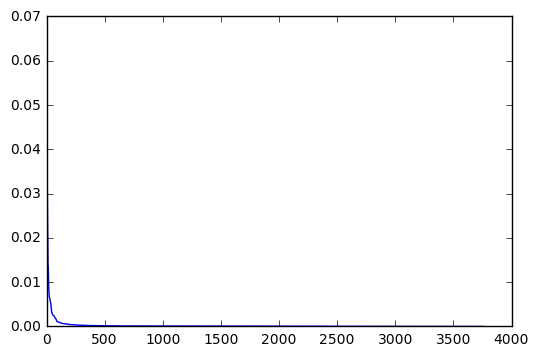

In [24]:
plt.plot(range(1,3755), features['importance'])

Let's try adjusting the class weights!

In [8]:
rf3b = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                class_weight='balanced',
                                random_state=1,
                                n_jobs=-1)
                            
rf3b = rf3b.fit(X_train, y_train.values.ravel())
print "%.4f" % rf3b.oob_score_ 

0.7870


In [9]:
scores3b = cross_val_score(rf3b, X_train, y_train.values.ravel(), n_jobs=-1)
scores3b.mean()

0.77979797979797982

In [74]:
predictions = rf3b.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test['status_group'].value_counts(normalize=True)

functional                 0.571515
non functional             0.356296
functional needs repair    0.072189
Name: status_group, dtype: float64

In [28]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:500])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8139


In [44]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

scores35 = cross_val_score(rf35, X_train[list(features['variable'][:500])], y_train.values.ravel(), n_jobs=-1)
scores35.mean()

0.80685185185185182

In [33]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:300])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8130


In [34]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:400])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8130


In [35]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:600])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8143


In [36]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:700])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8146


In [3]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:800])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

NameError: name 'features' is not defined

In [45]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

scores35 = cross_val_score(rf35, X_train[list(features['variable'][:800])], y_train.values.ravel(), n_jobs=-1)
scores35.mean()

0.80749158249158259

In [48]:
predictions = rf35.predict(X_test[list(features['variable'][:800])])
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files','y_test7.csv'), sep=",", index = False)

In [39]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:900])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8149


In [37]:
rf35 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf35 = rf35.fit(X_train[list(features['variable'][:1000])], y_train.values.ravel())
print "%.4f" % rf35.oob_score_ 

0.8143


# Model 4

#### Run model with 500 trees, tuned hyperparameters, construction 2

In [12]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction2(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [13]:
rf4 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf4 = rf4.fit(X_train, y_train.values.ravel())
print "%.4f" % rf4.oob_score_ 

0.8151


#### Obtain cross-validation score

In [19]:
scores = cross_val_score(rf4, X_train, y_train.values.ravel(), n_jobs=-1)
scores.mean()

0.80718855218855212

#### Inspect feature importance

In [16]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf2.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
3731,quantity_group_dry,0.069755
2,longitude,0.048945
3,latitude,0.047755
1,gps_height,0.035035
9,construction_year,0.032990
0,date_recorded,0.032718
3729,quantity_group_enough,0.030897
3750,waterpoint_type_other,0.026630
6,population,0.025845
3693,extraction_type_class_other,0.021139


#### Generate submission file

In [14]:
predictions = rf4.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv('y_test4.csv', sep=",", index = False)

It appears that out model is severely underestimating 'functional needs repair' status group and moderately underestimating the 'non functional' status group. 

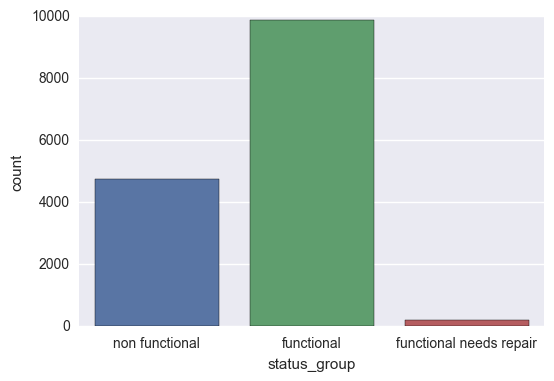

In [18]:
import seaborn as sns
%matplotlib inline

sns.countplot(y_test['status_group'])

# Model 5

#### Run model with 1000 trees, tuned hyperparameters, construction 2

In [8]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction2(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [9]:
rf5 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf5 = rf5.fit(X_train, y_train.values.ravel())
print "%.4f" % rf5.oob_score_ 

0.8144


#### Obtain cross-validation score

In [31]:
scores = cross_val_score(rf5, X_train, y_train.values.ravel(), n_jobs=-1)
scores.mean()

0.80710437710437721

#### Inspect feature importance

In [ ]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf2.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

#### Generate submission file

In [ ]:
predictions = rf6.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test6.csv'), sep=",", index = False)

# Model 6

#### Run model with 500 trees & 'funder' deleted

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
del X_train['funder']
del X_test['funder']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [6]:
np.shape(X_train)

(59400, 3017)

In [3]:
rf6 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

rf6 = rf6.fit(X_train, y_train.values.ravel())
print "%.4f" % rf6.oob_score_ 

0.8138


#### Obtain cross-validation score

In [4]:
scores = cross_val_score(rf6, X_train, y_train.values.ravel(), n_jobs=-1)
scores.mean()

0.80653198653198643

#### Generate submission file

In [7]:
predictions = rf6.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test6.csv'), sep=",", index = False)

# Model 8

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [12]:
rf8 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf8 = rf8.fit(X_train, y_train.values.ravel())
print "%.4f" % rf8.oob_score_ 

0.8144


In [13]:
predictions = rf8.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test8.csv'), sep=",", index = False)

# Model 9

In [14]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [15]:
rf9 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=2000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf9 = rf9.fit(X_train, y_train.values.ravel())
print "%.4f" % rf9.oob_score_ 

0.8143


In [16]:
predictions = rf9.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test9.csv'), sep=",", index = False)

# Model 10

Using LDA on population, gps_height, latitude, longitude.

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)

In [4]:
rf10 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf10 = rf10.fit(X_train, y_train.values.ravel())
print "%.4f" % rf10.oob_score_ 

0.8134


In [5]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf10.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
3731,quantity_group_dry,0.066108
3,latitude,0.040599
2,longitude,0.040133
3755,1,0.037542
3754,0,0.036553
9,construction_year,0.031104
1,gps_height,0.029522
0,date_recorded,0.029420
3729,quantity_group_enough,0.029278
3750,waterpoint_type_other,0.023684


In [6]:
predictions = rf10.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test10.csv'), sep=",", index = False)

# Model 11

Use LDA, drop correlated columns

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)

In [8]:
for i in ['population', 'gps_height', 'latitude', 'longitude']:
    del X_train[i]
    del X_test[i]

In [9]:
rf11 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf11 = rf11.fit(X_train, y_train.values.ravel())
print "%.4f" % rf11.oob_score_ 

0.8129


In [10]:
predictions = rf11.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test11.csv'), sep=",", index = False)

# Model 12
Use LDA, drop correlated columns

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [ ]:
for i in ['population', 'gps_height', 'latitude', 'longitude']:
    del X_train[i]
    del X_test[i]

In [11]:
rf12 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf12 = rf12.fit(X_train, y_train.values.ravel())
print "%.4f" % rf12.oob_score_ 

0.8131


In [12]:
predictions = rf12.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test12.csv'), sep=",", index = False)

# Model 13
Remove tiny columns

In [5]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['population', 'gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [6]:
babies = [i for i in X_train.columns if sum(X_train[i]) < 20]
dead_babies = [i for i in X_train.columns if i not in babies]

In [7]:
X_train = X_train.rename(index=str, columns={0: "a", 1: "c"})
X_test = X_test.rename(index=str, columns={0: "a", 1: "c"})

In [8]:
dead_babies.append('a')
dead_babies.append('c')

In [9]:
X_train = X_train[dead_babies]
X_test = X_test[dead_babies]

In [10]:
rf13 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf13 = rf13.fit(X_train, y_train.values.ravel())
print "%.4f" % rf13.oob_score_ 

0.8128


In [11]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf13.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
1822,quantity_group_dry,0.077667
1845,c,0.057460
1844,a,0.055945
0,date_recorded,0.039557
5,construction_year,0.038840
1820,quantity_group_enough,0.033737
1841,waterpoint_type_other,0.028383
1785,extraction_type_class_other,0.023789
1770,extraction_type_other,0.020571
1,region_code,0.015909


In [12]:
predictions = rf13.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test13.csv'), sep=",", index = False)

# Model 14
Convert region code and district code to dummy columns

In [9]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
rf14 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf14 = rf14.fit(X_train, y_train.values.ravel())
print "%.4f" % rf14.oob_score_ 

0.8142


In [10]:
predictions = rf14.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test14.csv'), sep=",", index = False)

# Model 15

Return district_code and region_code to numeric columns

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
rf15 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf15 = rf15.fit(X_train, y_train.values.ravel())
print "%.4f" % rf15.oob_score_ 

0.8141


In [4]:
predictions = rf15.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test15.csv'), sep=",", index = False)

# Model 17

In [13]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['population', 'gps_height', 
                                                                        'latitude', 'longitude', 'date_recorded',
                                                                       'construction_year'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
rf17 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf17 = rf17.fit(X_train, y_train.values.ravel())
print "%.4f" % rf17.oob_score_ 

0.8107


# Model 18

Remove tiny columns (less than 10 ones).

In [13]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['population', 'gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [14]:
babies = [i for i in X_train.columns if sum(X_train[i]) < 10]
dead_babies = [i for i in X_train.columns if i not in babies]

In [15]:
X_train = X_train.rename(index=str, columns={0: "a", 1: "c"})
X_test = X_test.rename(index=str, columns={0: "a", 1: "c"})

In [16]:
dead_babies.append('a')
dead_babies.append('c')

In [18]:
X_train = X_train[dead_babies]
X_test = X_test[dead_babies]

In [19]:
rf18 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf18 = rf18.fit(X_train, y_train.values.ravel())
print "%.4f" % rf18.oob_score_ 

0.8129


In [20]:
predictions = rf18.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test18.csv'), sep=",", index = False)

# Model 19

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, ['population', 'gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [4]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            max_features='auto',
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)

In [7]:
param_grid = { "min_samples_split" : [10, 12, 14]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [8]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.cv_results_)

0.799410774411
{'min_samples_split': 10}
{'std_train_score': array([ 0.00028978,  0.00037426,  0.00029031]), 'rank_test_score': array([1, 2, 3]), 'mean_score_time': array([  9.69799995,  10.32850003,   6.13999987]), 'param_min_samples_split': masked_array(data = [10 12 14],
             mask = [False False False],
       fill_value = ?)
, 'std_test_score': array([ 0.00197645,  0.00180812,  0.00147146]), 'split1_train_score': array([ 0.89374095,  0.88498704,  0.87801758]), 'split0_test_score': array([ 0.80138716,  0.80054544,  0.799064  ]), 'mean_test_score': array([ 0.79941077,  0.79873737,  0.79759259]), 'split0_train_score': array([ 0.89316139,  0.88423853,  0.87743695]), 'params': ({'min_samples_split': 10}, {'min_samples_split': 12}, {'min_samples_split': 14}), 'std_fit_time': array([ 1.17299998,  1.66100013,  5.45200002]), 'std_score_time': array([ 2.04299998,  2.46549988,  0.75300002]), 'mean_train_score': array([ 0.89345117,  0.88461278,  0.87772726]), 'mean_fit_time': array([ 2

In [10]:
rf19 = RandomForestClassifier(criterion='gini',
                                min_samples_split=10,
                                n_estimators=1000,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf19 = rf19.fit(X_train, y_train.values.ravel())
print "%.4f" % rf19.oob_score_ 

0.8140


In [19]:
kfold = StratifiedKFold(y=y_train.values.ravel(), n_folds=3, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    rf19.fit(X_train.values[train], y_train.values.ravel()[train])
    score = rf19.score(X_train.values[test], y_train.values.ravel()[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.4f' % (k+1, np.array(y_train['status_group'][train].value_counts()), score))

Fold: 1, Class dist.: [21506 15216  2878], Acc: 0.8074
Fold: 2, Class dist.: [21506 15216  2878], Acc: 0.8088
Fold: 3, Class dist.: [21506 15216  2878], Acc: 0.8053


In [20]:
predictions = rf19.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test19.csv'), sep=",", index = False)

# Model 20

Combine all the prior models and perform a majority vote.

In [17]:
y_test = pd.read_csv('y_test.csv')
del y_test['status_group']

In [18]:
for i in os.listdir('submission_files'):
    y_test = pd.concat((y_test, pd.read_csv(os.path.join('submission_files', i), usecols=[1])), axis=1)

In [25]:
y_test20 = pd.concat((y_test.iloc[:, 0], y_test.iloc[:, 1:].mode(axis=1)[0]), axis=1)

In [26]:
y_test20 = y_test20.rename(index=str, columns={0: "status_group"})

In [28]:
y_test20.to_csv(os.path.join('submission_files', 'y_test20.csv'), sep=",", index = False)

# Model 21

Collapse string values of less than 20 counts into 'other' category for categorical columns.

In [3]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.small_n(X_train, X_test)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test)

In [5]:
rf21 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf21 = rf21.fit(X_train, y_train.values.ravel())
print "%.4f" % rf21.oob_score_ 

0.8122


In [6]:
predictions = rf21.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test21.csv'), sep=",", index = False)

In [9]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf21.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
1775,quantity_group_dry,0.075938
1,1,0.055986
0,0,0.054953
7,construction_year,0.038938
2,date_recorded,0.038036
1773,quantity_group_enough,0.034419
1794,waterpoint_type_other,0.026702
1737,extraction_type_class_other,0.023779
1722,extraction_type_other,0.023088
3,region_code,0.016065


# Model 22

In [18]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.op_time(X_train, X_test)
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [19]:
rf22 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf22 = rf22.fit(X_train, y_train.values.ravel())
print "%.4f" % rf22.oob_score_ 

0.8130


In [20]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf22.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3730,quantity_group_dry,0.072002
1,1,0.051042
0,0,0.049795
7,construction_year,0.035234
8,operation_time,0.033199
2,date_recorded,0.033113
3728,quantity_group_enough,0.032331
3749,waterpoint_type_other,0.026084
3677,extraction_type_other,0.022564
3692,extraction_type_class_other,0.020699


In [21]:
sum(X_train['operation_time'])

2510704.8246576809

In [22]:
predictions = rf22.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test22.csv'), sep=",", index = False)

# Model 23

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.op_time(X_train, X_test)
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [13]:
del X_train['construction_year']
del X_test['construction_year']
del X_train['date_recorded']
del X_test['date_recorded']

In [14]:
rf23 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf23 = rf23.fit(X_train, y_train.values.ravel())
print "%.4f" % rf23.oob_score_ 

0.8116


In [16]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf23.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3728,quantity_group_dry,0.073531
1,1,0.057664
0,0,0.056215
6,operation_time,0.038815
3726,quantity_group_enough,0.032663
3747,waterpoint_type_other,0.028402
3690,extraction_type_class_other,0.025904
3675,extraction_type_other,0.019782
3712,payment_type_never pay,0.015555
8,month_recorded,0.015476


In [17]:
predictions = rf23.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test23.csv'), sep=",", index = False)

# Model 24

In [12]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train)
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [13]:
rf24 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf24 = rf24.fit(X_train, y_train.values.ravel())
print "%.4f" % rf24.oob_score_ 

0.8127


In [14]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf24.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3743,quantity_group_dry,0.070947
1,1,0.053800
0,0,0.052498
7,construction_year,0.036703
2,date_recorded,0.035575
3741,quantity_group_enough,0.032826
3762,waterpoint_type_other,0.025475
3705,extraction_type_class_other,0.021890
3690,extraction_type_other,0.020803
3727,payment_type_never pay,0.015461


In [15]:
predictions = rf24.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test24.csv'), sep=",", index = False)

# Model 25

In [7]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
#X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [8]:
rf25 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf25 = rf25.fit(X_train, y_train.values.ravel())
print "%.4f" % rf25.oob_score_ 

0.8129


In [9]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf25.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3730,quantity_group_dry,0.071292
1,1,0.051142
0,0,0.047803
2,date_recorded,0.034717
8,construction_year,0.034572
3728,quantity_group_enough,0.031591
5,population,0.028114
3749,waterpoint_type_other,0.027811
3677,extraction_type_other,0.022521
3692,extraction_type_class_other,0.018726


In [11]:
predictions = rf25.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test25.csv'), sep=",", index = False)

# Model 26

In [16]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [17]:
rf26 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf26 = rf26.fit(X_train, y_train.values.ravel())
print "%.4f" % rf26.oob_score_ 

0.8135


In [18]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf26.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3744,quantity_group_dry,0.071495
1,1,0.050266
0,0,0.047714
8,construction_year,0.034241
2,date_recorded,0.033337
3742,quantity_group_enough,0.031313
3763,waterpoint_type_other,0.030164
5,population,0.027584
3691,extraction_type_other,0.020502
3706,extraction_type_class_other,0.019930


In [19]:
predictions = rf26.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test26.csv'), sep=",", index = False)

# Model 27


In [20]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.op_time(X_train, X_test)
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.small_n(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [21]:
rf27 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf27 = rf27.fit(X_train, y_train.values.ravel())
print "%.4f" % rf27.oob_score_ 

0.8132


In [22]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf27.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
1791,quantity_group_dry,0.075210
1,1,0.050248
0,0,0.046613
8,construction_year,0.035945
2,date_recorded,0.032095
1789,quantity_group_enough,0.032057
9,operation_time,0.031715
5,population,0.027410
1810,waterpoint_type_other,0.027101
1738,extraction_type_other,0.022971


In [23]:
predictions = rf27.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test27.csv'), sep=",", index = False)

# Model 28

In [24]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.op_time(X_train, X_test)
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [25]:
rf28 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf28 = rf28.fit(X_train, y_train.values.ravel())
print "%.4f" % rf28.oob_score_ 

0.8136


In [26]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf28.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3745,quantity_group_dry,0.069151
1,1,0.048365
0,0,0.045296
8,construction_year,0.033830
9,operation_time,0.030643
2,date_recorded,0.030142
3743,quantity_group_enough,0.030025
5,population,0.026762
3764,waterpoint_type_other,0.025266
3692,extraction_type_other,0.020717


In [27]:
predictions = rf28.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test28.csv'), sep=",", index = False)

# Model 29

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal2(X_train, X_test)
X_train, X_test = feature_process_helper.small_n(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [5]:
rf29 = RandomForestClassifier(criterion='gini',
                                min_samples_split=12,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf29 = rf29.fit(X_train, y_train.values.ravel())
print "%.4f" % rf29.oob_score_ 

0.8131


In [6]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf29.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
2433,quantity_group_dry,0.069164
1,1,0.044177
0,0,0.041787
8,construction_year,0.033484
2431,quantity_group_enough,0.030782
2,date_recorded,0.030712
2452,waterpoint_type_other,0.026370
5,population,0.024170
2380,extraction_type_other,0.022948
2395,extraction_type_class_other,0.022852


In [7]:
predictions = rf29.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test29.csv'), sep=",", index = False)

# Model 30

In [8]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [15]:
rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = {"min_samples_split" : [10, 12, 16]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

The results of the above indicated that 10 was the optimal min_samples_split size for the given list.

In [12]:
rf30 = RandomForestClassifier(criterion='gini',
                                min_samples_split=10,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf30.fit(X_train, y_train.values.ravel())
print "%.4f" % rf30.oob_score_ 

0.8139


In [13]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf30.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3744,quantity_group_dry,0.069513
1,1,0.055489
0,0,0.052322
8,construction_year,0.034965
2,date_recorded,0.034585
5,population,0.029721
3742,quantity_group_enough,0.029714
3763,waterpoint_type_other,0.028127
3691,extraction_type_other,0.019552
3706,extraction_type_class_other,0.019322


In [14]:
predictions = rf30.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test30.csv'), sep=",", index = False)

# Model 31

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [ ]:
rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = {"min_samples_split" : [6, 8, 10]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [16]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.grid_scores_)

0.801178451178
{'min_samples_split': 8}
[mean: 0.80094, std: 0.00028, params: {'min_samples_split': 6}, mean: 0.80118, std: 0.00122, params: {'min_samples_split': 8}, mean: 0.80025, std: 0.00113, params: {'min_samples_split': 10}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [17]:
rf31 = RandomForestClassifier(criterion='gini',
                                min_samples_split=8,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf31.fit(X_train, y_train.values.ravel())
print "%.4f" % rf31.oob_score_ 

0.8147


In [18]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf31.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
3744,quantity_group_dry,0.068411
1,1,0.062008
0,0,0.058802
2,date_recorded,0.035965
8,construction_year,0.034847
5,population,0.033135
3742,quantity_group_enough,0.029409
3763,waterpoint_type_other,0.027029
3691,extraction_type_other,0.019009
3706,extraction_type_class_other,0.017998


In [19]:
predictions = rf31.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test31.csv'), sep=",", index = False)

# Model 32

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
del y_train['id']
X_train, X_test = feature_process_helper.dates(X_train, X_test)
X_train, X_test = feature_process_helper.dates2(X_train, X_test)
X_train, X_test = feature_process_helper.construction(X_train, X_test)
X_train, X_test = feature_process_helper.bools(X_train, X_test)
X_train, X_test = feature_process_helper.locs(X_train, X_test)
X_train['population'] = np.log(X_train['population'])
X_test['population'] = np.log(X_test['population'])
X_train, X_test = feature_process_helper.removal2(X_train, X_test)
X_train, X_test = feature_process_helper.small_n(X_train, X_test)
X_train, X_test = feature_process_helper.lda(X_train, X_test, y_train, cols = ['gps_height', 'latitude', 'longitude'])
X_train, X_test = feature_process_helper.dummies(X_train, X_test)

In [7]:
rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

param_grid = {"min_samples_split" : [4, 6, 8]}

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train.values.ravel())
#scores = cross_val_score(gs, X_train, y_train.values.ravel(), scoring='accuracy', cv=5)
#print('CV accuracy: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))

In [8]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.grid_scores_)

0.801531986532
{'min_samples_split': 6}
[mean: 0.80040, std: 0.00078, params: {'min_samples_split': 4}, mean: 0.80153, std: 0.00090, params: {'min_samples_split': 6}, mean: 0.80146, std: 0.00049, params: {'min_samples_split': 8}]


C:\Users\User\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [9]:
rf32 = RandomForestClassifier(criterion='gini',
                                min_samples_split=8,
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)
                            
rf32.fit(X_train, y_train.values.ravel())
print "%.4f" % rf32.oob_score_ 

0.8131


In [10]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(rf32.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variable,importance
2433,quantity_group_dry,0.065010
1,1,0.053245
0,0,0.051294
8,construction_year,0.033630
2,date_recorded,0.032911
2431,quantity_group_enough,0.029088
5,population,0.028243
2452,waterpoint_type_other,0.023807
2395,extraction_type_class_other,0.023125
2380,extraction_type_other,0.020625


In [11]:
predictions = rf32.predict(X_test)
y_test = pd.read_csv('y_test.csv')
pred = pd.DataFrame(predictions, columns = [y_test.columns[1]])
del y_test['status_group']
y_test = pd.concat((y_test, pred), axis = 1)
y_test.to_csv(os.path.join('submission_files', 'y_test32.csv'), sep=",", index = False)

# Model 33

In [12]:
y_test = pd.read_csv('y_test.csv')
del y_test['status_group']

In [13]:
ys = []
for i in os.listdir('submission_files'):
    ys.append(i)

In [22]:
ys.remove('y_test3.csv')

In [23]:
ys

['y_test20.csv',
 'y_test21.csv',
 'y_test22.csv',
 'y_test23.csv',
 'y_test24.csv',
 'y_test25.csv',
 'y_test26.csv',
 'y_test27.csv',
 'y_test28.csv',
 'y_test29.csv',
 'y_test30.csv',
 'y_test31.csv',
 'y_test32.csv']

In [24]:
for i in ys:
    y_test = pd.concat((y_test, pd.read_csv(os.path.join('submission_files', i), usecols=[1])), axis=1)

In [25]:
y_test33 = pd.concat((y_test.iloc[:, 0], y_test.iloc[:, 1:].mode(axis=1)[0]), axis=1)

In [26]:
y_test33 = y_test33.rename(index=str, columns={0: "status_group"})

In [27]:
y_test33.to_csv(os.path.join('submission_files', 'y_test33.csv'), sep=",", index = False)